In [1]:
# pip install plotly
# pip install plotly --upgrade

In [2]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].apply(lambda x: np.log(x) if x>0 else 0)
df_test['Fare'] = df_test['Fare'].apply(lambda x: np.log(x) if x>0 else 0)

## 3. Feature Engineering

- 가장 먼저 dataset에 존재하는 Null data를 채운다.


- null data를 어떻게 채우느냐에 따라 모델의 성능이 바뀐다.


- Feature engineering은 실제 모델 학습에 쓰려고 하는 것이므로, train set뿐만 아니라 test set에에도 적용해야한다.

### 3.1 Full Null
#### 3.1.1 Fill Null in Age using title

- Age에는 Null data가 177개나 있다. 이를 채울 수 있는 여러 아이디어가 있지만, 여기서는 title + statistics를 사용하도록 한다.


- 영어에서  Miss, Mrr, Mrs 같은 title이 존재한다. 각 탑승객의 이름에는 꼭 이런 title이 들어가게 되는데 이를 사용하도록 한다.


- pandas series에는 data를 string으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있다. 이를 사용하여 title을 쉽게 추출할 수 있다.


- 우선 title을 Initial column에 저장한다.

In [3]:
df_train['Age'].isnull().sum()

177

In [4]:
df_train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [5]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')  # extract the Salutations

df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')  # extract the Salutations

In [6]:
df_train['Initial'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Initial, dtype: object

- pandas의 crosstab을 이용해 Initial과 Sex간의 count를 살펴보자

In [7]:
pd.crosstab(df_train['Sex'], df_train['Initial']).style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 table을 참고하여, 남자, 여자가 사용하는 Initial을 구분해보자.  
replace method를 이용하면, 특정 데이터 값을 원하는 값으로 치환해준다.

In [8]:
a = pd.DataFrame(['a','b','c'])
a.replace(['a','b'],['z','x'], inplace=True)
a

,0
0,z
1,x
2,c


In [9]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], inplace=True)

In [10]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관계있는 Miss, Mrs가 생존률이 높음을 확인할 수 있다.

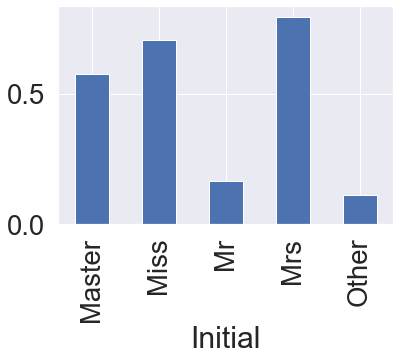

In [11]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 이제 본격적으로 Null data를 채운다. null data를 채우는 방법은 매우 다양하다. statistics를 사용하거나, Machine learning 알고리즘으로 예측해서 넣는 방식 등이 있다. 여기서는 statistics를 활용하는 방법을 사용한다.


- 여기서 statistics는 **train data의 것을 의미**한다. 우리는 언제나 test data를 unseen으로 두어야하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워주어야 한다.

In [12]:
# 두 개의 DataFrame 합치기 -- pandas에는 1) concat 2) merge가 있다. 여기선 concat사용한다.
df_all = pd.concat([df_train, df_test])
# Index를 새로하고 싶다면,
df_all = pd.concat([df_train, df_test]).reset_index()
# 인덱스 행을 없애고 싶다면,
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

In [13]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용해 Null value 를 채우도록 한다.


- pandas dataframe 을 다룰 때에는 boolean array를 이용해 indexing 하는 방법이 편하다.


- 아래 코드 첫줄을 해석하자면, isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다 이다.


- loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해져야한다.

In [14]:
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Mr'),'Age'] = 33
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Master'),'Age'] = 5
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Miss'),'Age'] = 22
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Mrs'),'Age'] = 36
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Other'),'Age'] = 46

In [15]:
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Mr'),'Age'] = 33
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Master'),'Age'] = 5
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Miss'),'Age'] = 22
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Mrs'),'Age'] = 36
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Other'),'Age'] = 46

In [16]:
df_train['Age'].isnull().sum()          # 더이상 Null data가 존재하지 않음을 확인가능하다.

0

In [17]:
df_test['Age'].isnull().sum()      # 더이상 Null data가 존재하지 않음을 확인가능하다.

0

### 3.12.3 Fill Null in Embarked

In [18]:
print('train: Embarked has {0} Null values'.format(df_train['Embarked'].isnull().sum()))
print('test: Embarked has {0} Null values'.format(df_test['Embarked'].isnull().sum()))

train: Embarked has 2 Null values
test: Embarked has 0 Null values


In [19]:
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

- Embarked는 Null value가 2개이고, S가 가장 많으므로 Null value를 S로 채운다.


- DataFrame의 fillna method를 사용하면 쉽게 채울 수 있다. 여기서, inplace = True 로 하면, df_train의 fillna를 실제로 적용하게 된다.

In [20]:
df_train['Embarked'].fillna('S', inplace=True)

In [21]:
print('train: Embarked has {0} Null values'.format(df_train['Embarked'].isnull().sum()))


train: Embarked has 0 Null values


In [22]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

## 3.2 Change Age(from continuous to categorical)


- Age 는 현재 continuous feature다. 이대로 써도 모델을 세울 수 있지만, Age 를 몇개의 group 으로 나누어 category 화 시켜줄 수 도 있다. continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있지만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 한다.



- 방법은 여러가지가 있다. dataframe 의 indexing 방법인 loc 를 사용하여 직접해줄 수 있고, 아니면 apply 를 사용해 함수를 넣어줄 수 있다.


- 첫번째로 loc 를 사용한 방법이다. loc 는 자주쓰게 되므로 그 사용법을 숙지하시면 좋다.


- 나이는 10살 간격으로 나누도록 한다.

In [23]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age']<10, 'Age_cat'] = 0
df_train.loc[(df_train['Age']>=10) & (df_train['Age']<20), 'Age_cat'] = 1
df_train.loc[(df_train['Age']>=20) & (df_train['Age']<30), 'Age_cat'] = 2
df_train.loc[(df_train['Age']>=30) & (df_train['Age']<40), 'Age_cat'] = 3
df_train.loc[(df_train['Age']>=40) & (df_train['Age']<50), 'Age_cat'] = 4
df_train.loc[(df_train['Age']>=50) & (df_train['Age']<60), 'Age_cat'] = 5
df_train.loc[(df_train['Age']>=60) & (df_train['Age']<70), 'Age_cat'] = 6
df_train.loc[(df_train['Age']>=70), 'Age_cat'] = 7

In [24]:
df_train.loc[:,['Age','Age_cat']].head()

,Age,Age_cat
0,22.0,2
1,38.0,3
2,26.0,2
3,35.0,3
4,35.0,3


In [25]:
df_test['Age_cat'] = 0
df_test.loc[df_test['Age']<10, 'Age_cat'] = 0
df_test.loc[(df_test['Age']>=10) & (df_test['Age']<20), 'Age_cat'] = 1
df_test.loc[(df_test['Age']>=20) & (df_test['Age']<30), 'Age_cat'] = 2
df_test.loc[(df_test['Age']>=30) & (df_test['Age']<40), 'Age_cat'] = 3
df_test.loc[(df_test['Age']>=40) & (df_test['Age']<50), 'Age_cat'] = 4
df_test.loc[(df_test['Age']>=50) & (df_test['Age']<60), 'Age_cat'] = 5
df_test.loc[(df_test['Age']>=60) & (df_test['Age']<70), 'Age_cat'] = 6
df_test.loc[(df_test['Age']>=70), 'Age_cat'] = 7

In [26]:
df_test.loc[:,['Age','Age_cat']].head()

,Age,Age_cat
0,34.5,3
1,47.0,4
2,62.0,6
3,27.0,2
4,22.0,2


- 두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법이다. 훨씬 수월하다.

In [27]:
def cat_age(x):
    if x<10:
        return 0
    elif x<20:
        return 1
    elif x<30:
        return 2
    elif x<40:
        return 3
    elif x<50:
        return 4
    elif x<60:
        return 5
    elif x<70:
        return 6
    else:
        return 7
    
df_train['Age_cat2'] = df_train['Age'].apply(cat_age)
df_test['Age_cat'] = df_test['Age'].apply(cat_age)

- 두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야한다.



- 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용한다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 준다.

In [28]:
print('1번 방법, 2번 방법 모두 같은 결과라면 True를 줘야한다 -> ', (df_train['Age_cat'] == df_train['Age_cat2']).all())

1번 방법, 2번 방법 모두 같은 결과라면 True를 줘야한다 ->  True


- 보다시피, 결과는 True로 둘 중 편한 걸 사용하면 된다.


- 이제 중복되는 Age_cat과 원래 column Age를 제거하도록 한다.

In [29]:
df_train.drop(['Age', 'Age_cat2'], axis=1, inplace=True)
df_test.drop('Age', axis=1, inplace=True)

In [30]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'Initial',
       'Age_cat'],
      dtype='object')

In [31]:
df_test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'FamilySize', 'Initial', 'Age_cat'],
      dtype='object')

## 3.3 Change Initial, Embarked and Sex (from string to numerical) 

- 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 한다.



- map method 를 가지고 간단히 할 수 있다.

In [32]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2,'Mrs':3,'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2,'Mrs':3,'Other':4})

- Embarked 도 C, Q, S로 이루어져 있다. map 을 이용해 바꿔보자.


- 그러기 앞서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보자. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있다.

In [33]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [34]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

- 위 방법을 통해, Embarked가 S, C, Q 세 가지로 이루어져있음을 볼 수 있다. 이제 map을 사용해 수치화시켜주자.

In [35]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0,'Q':1,'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0,'Q':1,'S':2})

- 한번 Null 이 사라졌는지 확인해보자. Embarked Column만 가져온 것은 하나의 pandas의 Series 객체므로, isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있다. 그리고 이것에 any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 된다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 될 것이다.

In [36]:
(df_train['Embarked'].isnull()).any()

False

In [37]:
(df_test['Embarked'].isnull()).any()

False

- Sex 도 Female, male 로 이루어져 있다. map 을 이용해 바꿔보자.

In [38]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

In [39]:
df_train['Sex'].value_counts()

1    577
0    314
Name: Sex, dtype: int64

- 이제 각 feature 간의 상관관계를 한번 보려고 한다. 두 변수 간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 아래와 같습니다.

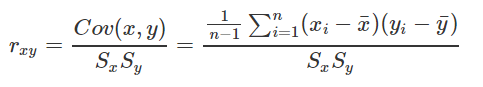


- 우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데, 이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있다.

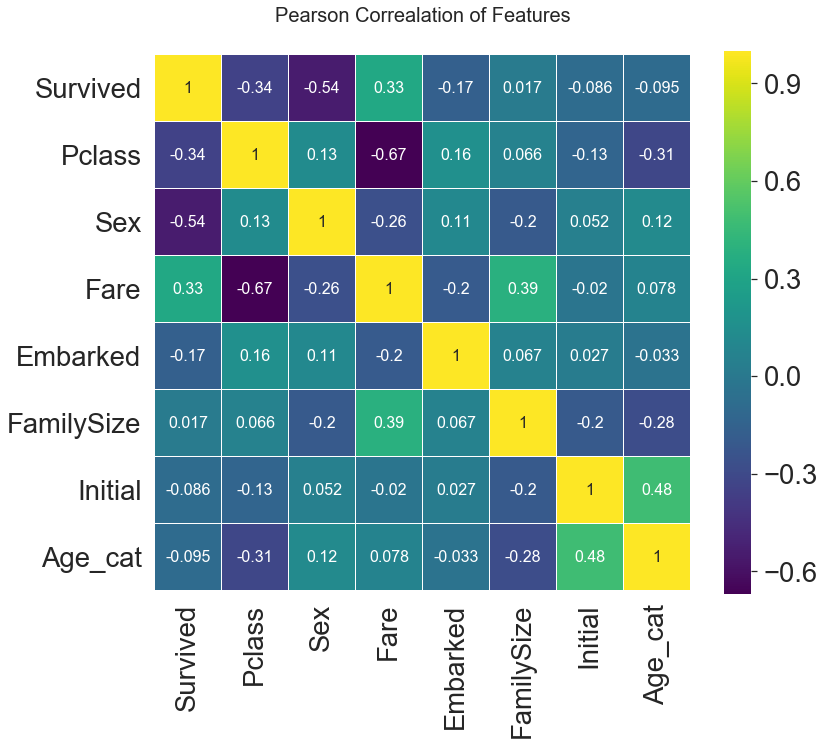

In [40]:
heatmap_data = df_train[['Survived','Pclass','Sex','Fare','Embarked','FamilySize','Initial','Age_cat']]

colormap = plt.cm.viridis

plt.figure(figsize=(12, 10))
plt.title('Pearson Correalation of Features', y=1.05, size=20)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1,
           vmax=1.0, square=True, cmap=colormap, linecolor='white',
           annot=True, annot_kws={'size': 16})

- EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있다.


- 생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있다.


- 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것이다.


- 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미한다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나이기 때문이다.


- 이제 실제로 모델을 학습시키기 앞서서 data preprocessing (전처리)을 진행해보도록 한다.

## 3.4 One -hot encoding on Initial and Embarked

- 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있다.


- 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말한다.


- One-hot encoding 은 위 카테고리를 아래와 같이 (0, 1) 로 이루어진 5차원의 벡터로 나타내는 것을 말한다. 더미변수와 비슷하지만 더미변수처럼 c-1개가 아닌 c개의 변수를 만들어 준다!

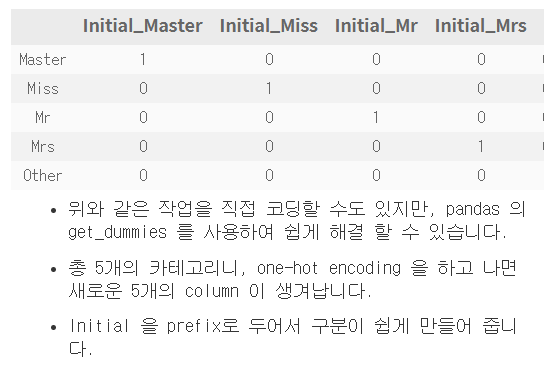

In [41]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [42]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [43]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [44]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,1,2,0,1,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,3,0,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,1,3,0,0,1,0,0,0,0,1


- sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능하다.


- 가끔 category 가 100개가 넘어가는 경우가 있다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보도록 한다.

## 3.5 Drop columns

- 이제 필요한 column만 남기고 다 지운다.

In [45]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'FamilySize', 'Age_cat', 'Initial_0',
       'Initial_1', 'Initial_2', 'Initial_3', 'Initial_4', 'Embarked_0',
       'Embarked_1', 'Embarked_2'],
      dtype='object')

In [46]:
df_train.drop(['PassengerId', 'Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)

In [47]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [48]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


- 보다시피, train 의 Survived feature(target class)를 빼면 train, test 둘다 같은 columns 를 가진 걸 확인할 수 있다.